# Demo for Property Inference Attack (PIA)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/privML/privacy-evaluator/blob/team2sprint4/notebooks/property_inference_attack.ipynb) [![Open in Github](https://raw.githubusercontent.com/privML/privacy-evaluator/main/notebooks/images/GitHub-Mark-32px.png)](https://github.com/privML/privacy-evaluator/blob/team2sprint4/notebooks/property_inference_attack.ipynb)

## Overview
In this notebook, we want to show you how to use the privacy-evaluator tool to perform the Property Inference Attack on a provided Pytorch model trained with the MNIST dataset. \
The goal of the Property Inference Attack is to find out whether the training dataset of a given model has a specific property (for more detailed information about the property inference attack take a look at [this paper](https://dl.acm.org/doi/pdf/10.1145/3243734.3243834) or at [Youtube](https://www.youtube.com/watch?v=99YHPIsKzCc&)).


![Property_Inference_Attack](https://i.imgur.com/IX1M3TX.png)


In our example the property we're trying to find out is the class distribution of the training dataset.

## Setup

First, you should set the notebook's runtime to use a GPU (e.g. if Colab is used go to ***Runtime > Change runtime type > Hardware accelerator***). Now we can install the `privacy-evaluator` package and import all needed modules.

In [7]:
!pip3 install git+https://github.com/privML/privacy-evaluator@team2sprint4

  Cloning https://github.com/privML/privacy-evaluator (to revision team2sprint4) to /tmp/pip-req-build-lr7lmz7q
  Running command git clone -q https://github.com/privML/privacy-evaluator /tmp/pip-req-build-lr7lmz7q
  Running command git checkout -b team2sprint4 --track origin/team2sprint4
  Switched to a new branch 'team2sprint4'
  Branch 'team2sprint4' set up to track remote branch 'team2sprint4' from 'origin'.
  Created wheel for privacy-evaluator: filename=privacy_evaluator-0.1-py3-none-any.whl size=28617451 sha256=225d1f485fe65bef4bce0eec03c74fe177d8cadb791a6e7af093effe2db427a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-yci7dner/wheels/17/a8/12/f05e8cd0aa70c8b9696e12d21946242d012c4ba1d6b54d9d6c
Successfully built privacy-evaluator


In [28]:
from privacy_evaluator.attacks.property_inference_attack import PropertyInferenceAttack
from privacy_evaluator.classifiers.classifier import Classifier
from privacy_evaluator.utils.data_utils import (
    dataset_downloader,
    new_dataset_from_size_dict,
)
from privacy_evaluator.utils.trainer import trainer
from privacy_evaluator.models.torch.cnn import ConvNet

import collections
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Conduct Property Inference Attack
Now we can start with conducting the Property Inference Attack.


## 1.1 Overview of the dataset
We will work with the MNIST dataset.\
MNIST is a dataset of black-and-white handwritten digits from 10 classes (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), consisting of 60000 training- and 10000 test-images.\
You can see some sample images of the MNIST dataset printed below.



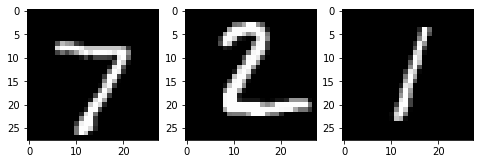

In [5]:
#Print images
images = test_dataset[0][:3]
_, axs = plt.subplots(1, 3, figsize=(8, 8))
axs = axs.flatten()
for image, ax in zip(images, axs):
    ax.imshow(image, cmap='gray')
plt.show()

## 1.2 Download of the dataset

First, we download the MNIST dataset.\
The size of each image is $28\times 28 \times 1$.


In [20]:
train_dataset, test_dataset = dataset_downloader("MNIST")
input_shape = test_dataset[0][0].shape
print(f"Input shape of images: {input_shape}")

Input shape of images: (28, 28, 1)


## 1.3 Adjustment of dataset to binary attack
As of now, we can only perform binary attacks.\
A binary attack is a attack, where the target model is only classifying into 2 different classes.\
This means that the dataset the target model is trained on only contain two different classes. For our example we therefore use classes 0 and 1 from MNIST, which represent the digits 0 and 1.

We specify a distribution of these two classes (`NUM_ELEMENTS_PER_CLASSES`) and adjust the MNIST dataset accordingly. \
On this adjusted dataset we will train our target model and later the attacks goal is to predict this distribution.

In [18]:
NUM_ELEMENTS_PER_CLASSES = {0: 1000, 1: 500}
train_set = new_dataset_from_size_dict(train_dataset, NUM_ELEMENTS_PER_CLASSES)
print(f"Amount of images per class: {NUM_ELEMENTS_PER_CLASSES}")
print(f"Amount of images in total: {train_set[1].shape}")
print(f"Size of each image: {train_set[0][0].shape}")

Amount of images per class: {0: 1000, 1: 500}
Amount of images in total: (1500,)
Size of each image: (28, 28, 1)


## 2. Load and train target model
We now load our target model.\
We use a convolutional neural network (CNN) and train it on the dataset created in the step before. \
We then convert it to an ART classifier to make it compatible with the [Adversial Robustness Toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox). This step is not important to understand for the actual attack but might be interesting to know for you if know the ART.

Our target model is now all set for the actual attack on it.


In [21]:
num_classes = len(NUM_ELEMENTS_PER_CLASSES)
model = ConvNet(num_classes, input_shape, num_channels=(input_shape[-1], 16, 32, 64))
trainer(train_set, NUM_ELEMENTS_PER_CLASSES, model, num_epochs=8)

# Convert to ART classifier

target_model = Classifier._to_art_classifier(model, "sparse_categorical_crossentropy", num_classes, input_shape)

## 3. Perform attack

### 3.1 Overview over whole attack
One property inference attack consists of several property inference sub-attacks for different distributions of the training data. One subattack is running for one ratio (e.g. 66% class 0, 34% class 1) and predicts whether it's more likely that the distribution of the training data of the target model was according to this special ratio or a balanced distribution (50% class 0, 50% class 1). \
We specify the ratios in `ratios_for_attack`. We only specify one ratio for class 0 in the list, the other one for class 1 is automatically computed in the attack (1 - ratio for class 0). \
The whole attack then checks, which distribution of the subattacks has the highest probability.

![Property_Inference_Attack_overview](https://i.imgur.com/yHPc8bO.png)

### 3.2 Overview over a subattack
In every subattack we create a number of shadow classifiers of the same architecture as the provided target model.

![shadow_classifiers](https://i.imgur.com/vffpROO.jpg)

Half of the shadow classifiers will be trained on an unbalanced data set of the given ratio (e.g. 70% class 0, 30% class 1) - our property -, the other half is trained on a balanced data sets (50% class 0, 50% class 1) - our negation of property.

![shadow_training_sets](https://i.imgur.com/ryUDdbK.jpg)

Once created and trained, the features of the shadow classifiers are extracted. Generally speaking, the extracted features are nothing more than on what specifics of the image the model determined its prediction. \
The extracted features are then the training data for the meta classifier. This means that the meta classifier is trained to distinguish between the property and the negation of property (unbalanced with specific ratio vs. balanced).

![meta_classifier](https://i.imgur.com/mhpkRm2.jpg)

Hence, the meta classifier gets as an input the feature extraction of the target model. 

If the data set used for the target model does indeed follow the property (unbalanced with specific ratio), the extracted features of the target model will show simularities to the feature extractions of the shadow classifiers trained on data sets that follow the property. Thus, the meta classifier will predict in this case that the likelihood of the target model to have the given property is higher than it having the negation of the property (similar procedure in the opposite case that the data set of the target model follows the negation of the property). 

To conclude, the meta classifier is the model which finally predicts the likelihood of the target model to have a given property (i.e. the ratio).

![prediction](https://i.imgur.com/Skf8j7S.jpg)


### 3.3 Perform actual attack
We first define the `number_of_shadow_classifiers`. In `size_set` we define the size of the training data sets for each shadow classifier. For both parameters we chose a really small numbers due to runtime issues, but for a real attack <1000 shadow classifiers are not recommended and also the size set should be increased according to the size of the dataset you're sampling from. In the case of MNIST set sizes between 500 and 1500 are reasonable.

In [26]:
# Number of shadow classifiers (increase for better accuracy of the meta classifier, decrease when not enough computing power is available.)
number_of_shadow_classifiers = 2 #needs to be even

# Size of data set to train the shadow classifiers
size_set = 6
#Ratios to perform the attack for (the real ratios of our example target model is 0.66: {0: 1000, 1: 500}: 66% of data points are from class 0, 33% from class 1.)
ratios_for_attack = [0.66,0.05]
classes = [0,1]

Now we perform the attack and safe the output in the variable `output`. The output consists of two elements. One is a string with a message where the actual prediction is printed. The other one is a dictionary where for every ratio specified before in `ratios_for attack` we get the likelihood that the training set was this ratio.

In [27]:
attack = PropertyInferenceAttack(target_model, train_set, verbose=1, size_set=size_set, \
    ratios_for_attack=ratios_for_attack, classes=classes,amount_sets=number_of_shadow_classifiers)
output = attack.attack()

Initiating Property Inference Attack ... 
Extracting features from target model ... 
(97634,)  --- features extracted from the target model.
Creating set of 1 balanced shadow classifiers ... 
Creating shadow training sets
Training shadow classifiers
Performing PIA for various ratios ... 
  0%|          | 0/2 [00:00<?, ?it/s]Creating shadow training sets
Training shadow classifiers
Epoch 1/2
1/1 [==============================] - 24s 24s/step - loss: 0.3359 - accuracy: 1.0000
Epoch 2/2
 50%|█████     | 1/2 [00:44<00:44, 44.19s/it]Creating shadow training sets
Training shadow classifiers
Epoch 1/2
1/1 [==============================] - 24s 24s/step - loss: 0.2151 - accuracy: 1.0000
Epoch 2/2
100%|██████████| 2/2 [01:11<00:00, 35.62s/it]


The human readable output message is the string, it gives us the actual prediction:

In [30]:
output[0]

'The most probable property is class 0: 0.95, class 1: 0.05 with a probability of 0.50660240650177.'

And the more detailed output you could use for visualization or further analysis is the dictionary.
If all the probabilities are close to 0.5 and none is standing out significantly from all the others you could try using more shadow classifiers (= make the training set for the meta classifier larger).

In [31]:
output[1]

{'class 0: 0.95, class 1: 0.05': 0.5066024,
 'class 0: 0.34, class 1: 0.66': 0.492016}